In [1]:
import sys
sys.path.append('../../../')
import os
import pandas as pd
import glob
import numpy as np
from impedance.circuits import Randles, CustomCircuit
import matplotlib.pyplot as plt
from impedance.plotting import plot_nyquist
# import impedance as imp

In [2]:
direc=r'\\ADLERNAS\admin\BrianGerwe\Research\Data\fr-XAS\July18 Data\Versastat'

all_files=glob.glob(direc+ '\*_700C_*_EIS_*.par')
all_files.sort()

In [39]:
dat=pd.read_csv(all_files[1],delimiter=',',engine='python',skiprows=115).apply(pd.to_numeric,errors='coerce')
# dat=dat.apply(pd.to_numeric,errors='coerce')
dat.dropna(how='all',inplace=True)
print(dat.columns)

Index(['Definition=Segment #', ' Point #', ' E(V)', ' I(A)',
       ' Elapsed Time(s)', ' ADC Sync Input(V)', ' Current Range', ' Status',
       ' E Applied(V)', ' Frequency(Hz)', ' E Real', ' E Imag', ' I Real',
       ' I Imag', ' Z Real', ' Z Imag', ' E2 Status', ' E2(V)', ' E2 Real',
       ' E2 Imag', ' Z2 Real', ' Z2 Imag', ' ActionId', ' AC Amplitude', ' 0'],
      dtype='object')


In [40]:
freqs=np.array(dat[' Frequency(Hz)'],ndmin=1)
Z=np.array(dat[' Z Real']+1j*dat[' Z Imag'],ndmin=1)

freqs = freqs[np.imag(Z) < 0]
Z = Z[np.imag(Z) < 0]

In [132]:
# Some initial guess values for all circuits
d=266e-9 #thickness of Al2O3 mask
A=3e-3*3e-3-(6*1e-3*4e-6) #Area of mask minus area of electrode gates

R_elyte=58

C_if=1.4e-6
R_if=15

C_mask=9.7*8.854e-12*8.976e-6/266e-9 #permitivity=9.7 thickness=266 nm
R_mask=3.54e5*d/A
R_chem=1600
C_chem=2.23e-4

min_ind=np.argmin(np.imag(Z[:]))
tg_init=freqs[min_ind]
K_init=1/tg_init
Y_init=1600/np.sqrt(tg_init)


Circuit string: R0-p(R1,C1)-p(R2,E2)
Fit: True

Initial guesses:
     R0 = 5.80e+01 [Ohm]
     R1 = 1.50e+01 [Ohm]
     C1 = 1.40e-06 [F]
     R2 = 1.60e+03 [Ohm]
   E2_0 = 2.23e-04 [Ohm^-1 sec^a]
   E2_1 = 9.50e-01 []

Fit parameters:
     R0 = 5.92e+01  (+/- 3.32e+00) [Ohm]
     R1 = 8.14e+00  (+/- 3.32e+00) [Ohm]
     C1 = 1.13e-06  (+/- 1.13e-06) [F]
     R2 = 1.54e+03  (+/- 4.11e+00) [Ohm]
   E2_0 = 3.06e-04  (+/- 1.50e-06) [Ohm^-1 sec^a]
   E2_1 = 7.16e-01  (+/- 2.44e-03) []



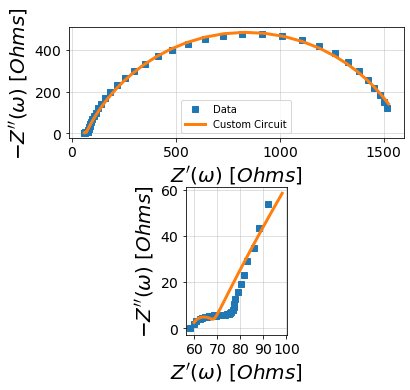

In [122]:
inits=[R_elyte,R_if,C_if,R_chem,C_chem,.95]
circ='R0-p(R1,C1)-p(R2,E2)'

circuit1=CustomCircuit(initial_guess=inits,circuit=circ)
circuit1.fit(freqs,Z)
print(circuit1)

pred_freq=np.logspace(np.log10(freqs[0]),np.log10(freqs[-1]),num=freqs.size)
custom_fit1=circuit1.predict(pred_freq)

fig=plt.figure(figsize=(6,6))
ax0=fig.add_subplot(211)
plot_nyquist(ax0, freqs, Z,fmt='s')
plot_nyquist(ax0, pred_freq,custom_fit1,fmt='-')

ax1=fig.add_subplot(212)
plot_nyquist(ax1,freqs[:30],Z[:30],fmt='s')
plot_nyquist(ax1,pred_freq[:30],custom_fit1[:30],fmt='-')

ax0.legend(['Data','Custom Circuit'])


Circuit string: R0-p(R1,C1)-G1
Fit: True

Initial guesses:
     R0 = 5.80e+01 [Ohm]
     R1 = 1.50e+01 [Ohm]
     C1 = 1.40e-06 [F]
   G1_0 = 2.35e+03 [Ohm^-1 sec^1/2]
   G1_1 = 2.15e+00 [sec^-1]

Fit parameters:
     R0 = 2.41e-02  (+/- 2.00e+00) [Ohm]
     R1 = 4.38e+01  (+/- 2.00e+00) [Ohm]
     C1 = 8.18e-39  (+/- 2.19e-08) [F]
   G1_0 = 1.58e+03  (+/- 1.62e+01) [Ohm^-1 sec^1/2]
   G1_1 = 1.19e+00  (+/- 2.62e-02) [sec^-1]



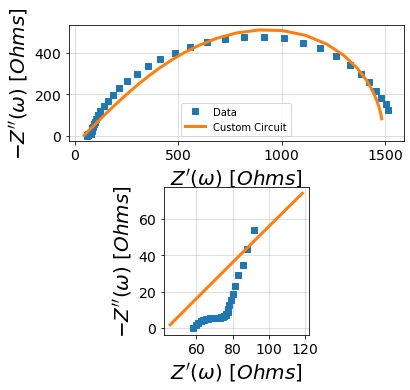

In [114]:
inits=[R_elyte,R_if,C_if,Y_init,K_init]
circ='R0-p(R1,C1)-G1'

circuit2=CustomCircuit(initial_guess=inits,circuit=circ)
circuit2.fit(freqs,Z)
print(circuit2)

pred_freq=np.logspace(np.log10(freqs[0]),np.log10(freqs[-1]),num=freqs.size)
custom_fit2=circuit2.predict(pred_freq)

fig=plt.figure(figsize=(6,6))
ax0=fig.add_subplot(211)
plot_nyquist(ax0, freqs, Z,fmt='s')
plot_nyquist(ax0, pred_freq,custom_fit2,fmt='-')

ax1=fig.add_subplot(212)
plot_nyquist(ax1,freqs[:30],Z[:30],fmt='s')
plot_nyquist(ax1,pred_freq[:30],custom_fit2[:30],fmt='-')

ax0.legend(['Data','Custom Circuit'])


Circuit string: R0-p(C2,p(R1,C1)-G1)
Fit: True

Initial guesses:
     R0 = 5.80e+01 [Ohm]
     C2 = 3.90e-09 [F]
     R1 = 1.50e+01 [Ohm]
     C1 = 1.40e-06 [F]
   G1_0 = 2.35e+03 [Ohm^-1 sec^1/2]
   G1_1 = 2.15e+00 [sec^-1]

Fit parameters:
     R0 = 6.43e+01  (+/- 4.56e+00) [Ohm]
     C2 = 1.93e-05  (+/- 4.51e-05) [F]
     R1 = 3.63e-11  (+/- 1.30e+02) [Ohm]
     C1 = 4.93e+01  (+/- 3.33e-14) [F]
   G1_0 = 1.63e+03  (+/- 7.57e+01) [Ohm^-1 sec^1/2]
   G1_1 = 1.31e+00  (+/- 1.29e-01) [sec^-1]



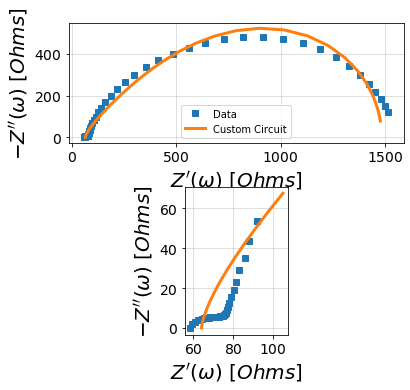

In [117]:
min_ind=np.argmin(np.imag(Z[:]))

inits=[R_elyte,C_mask,R_if,C_if,Y_init,K_init]
circ='R0-p(C2,p(R1,C1)-G1)'

circuit3=CustomCircuit(initial_guess=inits,circuit=circ)
circuit3.fit(freqs,Z)
print(circuit3)

pred_freq=np.logspace(np.log10(freqs[0]),np.log10(freqs[-1]),num=freqs.size)
custom_fit3=circuit3.predict(pred_freq)


fig=plt.figure(figsize=(6,6))
ax0=fig.add_subplot(211)
plot_nyquist(ax0, freqs, Z,fmt='s')
plot_nyquist(ax0, pred_freq,custom_fit3,fmt='-')

ax1=fig.add_subplot(212)
plot_nyquist(ax1, freqs, Z[:30],fmt='s')
plot_nyquist(ax1, pred_freq,custom_fit3[:30],fmt='-')
# plot_nyquist(ax1,freqs[:30],Z[:30],fmt='s')
# plot_nyquist(ax1,pred_freq[:30],custom_fit2[:30],fmt='-')

ax0.legend(['Data','Custom Circuit'])


Circuit string: R0-p(E2,p(R1,C1)-G1)
Fit: True

Initial guesses:
     R0 = 5.80e+01 [Ohm]
   E2_0 = 2.90e-09 [Ohm^-1 sec^a]
   E2_1 = 9.50e-01 []
     R1 = 1.50e+01 [Ohm]
     C1 = 1.40e-06 [F]
   G1_0 = 2.35e+03 [Ohm^-1 sec^1/2]
   G1_1 = 2.15e+00 [sec^-1]

Fit parameters:
     R0 = 6.78e+01  (+/- 6.78e-01) [Ohm]
   E2_0 = 2.55e-04  (+/- 6.04e-06) [Ohm^-1 sec^a]
   E2_1 = 7.54e-01  (+/- 7.27e-03) []
     R1 = 2.44e+02  (+/- 1.80e+01) [Ohm]
     C1 = 1.98e-03  (+/- 1.88e-04) [F]
   G1_0 = 1.42e+04  (+/- 1.14e+04) [Ohm^-1 sec^1/2]
   G1_1 = 1.26e+02  (+/- 2.01e+02) [sec^-1]



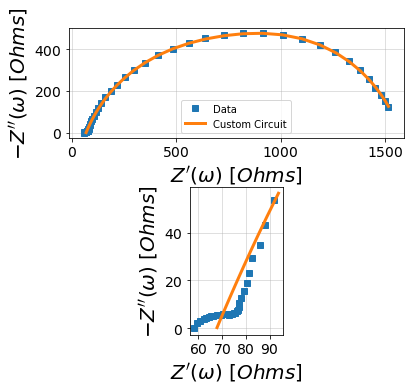

In [139]:
inits=[R_elyte,C_mask,.95,R_if,C_if,Y_init,K_init]
circ='R0-p(E2,p(R1,C1)-G1)'

circuit4=CustomCircuit(initial_guess=inits,circuit=circ)
circuit4.fit(freqs,Z)
print(circuit4)

pred_freq=np.logspace(np.log10(freqs[0]),np.log10(freqs[-1]),num=freqs.size)
custom_fit4=circuit4.predict(pred_freq)


fig=plt.figure(figsize=(6,6))
ax0=fig.add_subplot(211)
plot_nyquist(ax0, freqs, Z,fmt='s')
plot_nyquist(ax0, pred_freq,custom_fit4,fmt='-')

ax1=fig.add_subplot(212)
plot_nyquist(ax1, freqs, Z[:30],fmt='s')
plot_nyquist(ax1, pred_freq,custom_fit4[:30],fmt='-')
# plot_nyquist(ax1,freqs[:30],Z[:30],fmt='s')
# plot_nyquist(ax1,pred_freq[:30],custom_fit2[:30],fmt='-')

ax0.legend(['Data','Custom Circuit'])


Circuit string: R0-p(C2,R2,p(R1,C1)-G1)
Fit: True

Initial guesses:
     R0 = 5.80e+01 [Ohm]
     C2 = 2.90e-09 [F]
     R2 = 1.05e+04 [Ohm]
     R1 = 1.50e+01 [Ohm]
     C1 = 1.40e-06 [F]
   G1_0 = 2.35e+03 [Ohm^-1 sec^1/2]
   G1_1 = 2.15e+00 [sec^-1]

Fit parameters:
     R0 = 7.16e+01  (+/- 6.85e-01) [Ohm]
     C2 = 5.47e-05  (+/- 1.15e-06) [F]
     R2 = 1.59e+03  (+/- 6.00e+01) [Ohm]
     R1 = 7.46e+03  (+/- 4.97e+03) [Ohm]
     C1 = 7.75e-04  (+/- 1.41e-04) [F]
   G1_0 = 2.51e+03  (+/- 4.21e+01) [Ohm^-1 sec^1/2]
   G1_1 = 6.99e-22  (+/- 5.03e-02) [sec^-1]



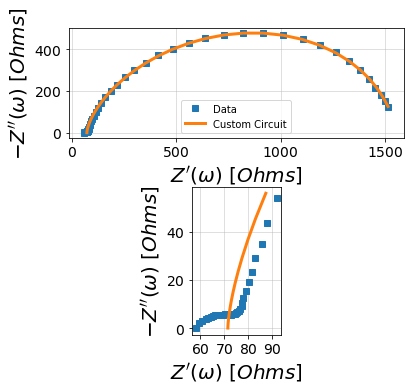

In [134]:
inits=[R_elyte,C_mask,R_mask,R_if,C_if,Y_init,K_init]
circ='R0-p(C2,R2,p(R1,C1)-G1)'

circuit5=CustomCircuit(initial_guess=inits,circuit=circ)
circuit5.fit(freqs,Z)
print(circuit5)

pred_freq=np.logspace(np.log10(freqs[0]),np.log10(freqs[-1]),num=freqs.size)
custom_fit5=circuit5.predict(pred_freq)


fig=plt.figure(figsize=(6,6))
ax0=fig.add_subplot(211)
plot_nyquist(ax0, freqs, Z,fmt='s')
plot_nyquist(ax0, pred_freq,custom_fit5,fmt='-')

ax1=fig.add_subplot(212)
plot_nyquist(ax1, freqs, Z[:30],fmt='s')
plot_nyquist(ax1, pred_freq,custom_fit5[:30],fmt='-')
# plot_nyquist(ax1,freqs[:30],Z[:30],fmt='s')
# plot_nyquist(ax1,pred_freq[:30],custom_fit2[:30],fmt='-')

ax0.legend(['Data','Custom Circuit'])


Circuit string: R0-p(E2,R2,p(R1,C1)-G1)
Fit: True

Initial guesses:
     R0 = 5.80e+01 [Ohm]
   E2_0 = 2.90e-09 [Ohm^-1 sec^a]
   E2_1 = 8.00e-01 []
     R2 = 1.05e+04 [Ohm]
     R1 = 1.50e+01 [Ohm]
     C1 = 1.40e-06 [F]
   G1_0 = 2.35e+03 [Ohm^-1 sec^1/2]
   G1_1 = 2.15e+00 [sec^-1]

Fit parameters:
     R0 = 5.86e+01  (+/- 2.88e+00) [Ohm]
   E2_0 = 1.85e-04  (+/- 7.62e-05) [Ohm^-1 sec^a]
   E2_1 = 6.77e-01  (+/- 5.03e-02) []
     R2 = 7.59e+03  (+/- 7.65e+03) [Ohm]
     R1 = 5.65e+01  (+/- 1.65e+02) [Ohm]
     C1 = 3.63e-02  (+/- 1.05e-01) [F]
   G1_0 = 2.98e+03  (+/- 8.88e+02) [Ohm^-1 sec^1/2]
   G1_1 = 2.62e+00  (+/- 1.14e+00) [sec^-1]



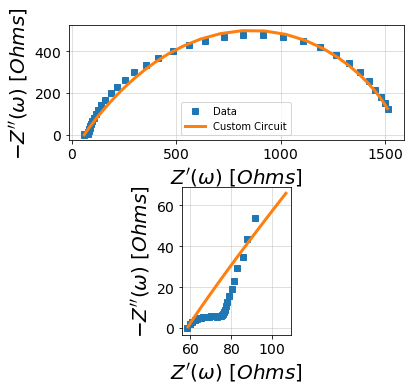

In [138]:
inits=[R_elyte,C_mask,.8,R_mask,R_if,C_if,Y_init,K_init]
circ='R0-p(E2,R2,p(R1,C1)-G1)'

circuit6=CustomCircuit(initial_guess=inits,circuit=circ)
circuit6.fit(freqs,Z)
print(circuit6)

pred_freq=np.logspace(np.log10(freqs[0]),np.log10(freqs[-1]),num=freqs.size)
custom_fit6=circuit6.predict(pred_freq)


fig=plt.figure(figsize=(6,6))
ax0=fig.add_subplot(211)
plot_nyquist(ax0, freqs, Z,fmt='s')
plot_nyquist(ax0, pred_freq,custom_fit6,fmt='-')

ax1=fig.add_subplot(212)
plot_nyquist(ax1, freqs, Z[:30],fmt='s')
plot_nyquist(ax1, pred_freq,custom_fit6[:30],fmt='-')
# plot_nyquist(ax1,freqs[:30],Z[:30],fmt='s')
# plot_nyquist(ax1,pred_freq[:30],custom_fit2[:30],fmt='-')

ax0.legend(['Data','Custom Circuit'])

Simulating circuit based on initial parameters
Simulating circuit based on initial parameters
Simulating circuit based on initial parameters


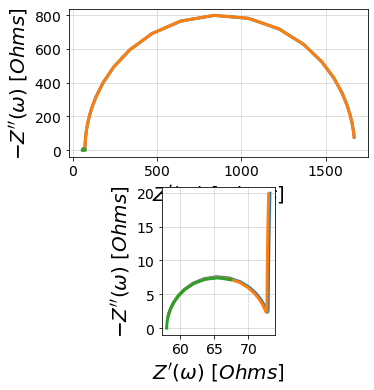

In [148]:
circuita=CustomCircuit(initial_guess=[R_elyte,R_if,C_if,R_chem,C_chem],circuit='R0-p(R1,C1)-p(R2,C2)')
Pred_a=circuita.predict(pred_freq,use_initial=True)

circuitb=CustomCircuit(initial_guess=[R_elyte,C_if,R_if,R_chem,C_chem],circuit='R0-p(C1,R1-p(R2,C2))')
Pred_b=circuitb.predict(pred_freq,use_initial=True)

circuitc=CustomCircuit(initial_guess=[R_elyte,C_if,R_if,R_chem,C_chem],circuit='R0-p(C1,R1,p(R2,C2))')
Pred_c=circuitc.predict(pred_freq,use_initial=True)

fig=plt.figure(figsize=(6,6))
ax0=fig.add_subplot(211)
plot_nyquist(ax0, pred_freq,Pred_a,fmt='-')
plot_nyquist(ax0, pred_freq,Pred_b,fmt='-')
plot_nyquist(ax0, pred_freq,Pred_c,fmt='-')

ax1=fig.add_subplot(212)

plot_nyquist(ax1, pred_freq,Pred_a[:30],fmt='-')
plot_nyquist(ax1, pred_freq,Pred_b[:30],fmt='-')
plot_nyquist(ax1, pred_freq,Pred_c[:30],fmt='-')

C:\Users\Modeling\Miniconda3\envs\impedance-analysis\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\Modeling\Miniconda3\envs\impedance-analysis\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Modeling\Miniconda3\envs\impedance-analysis\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\Modeling\Miniconda3\envs\impedance-analysis\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide


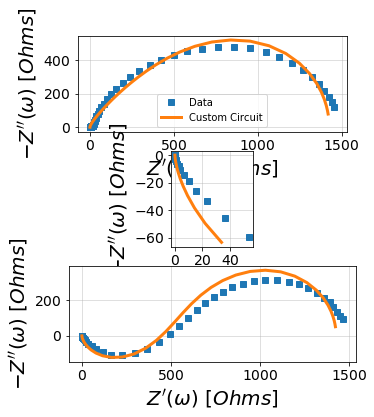

In [160]:
Z_corr=Z-Z[0]
inits=[C_mask,R_if,C_if,Y_init,K_init]
circ='p(C2,p(R1,C1)-G1)'

# circuit7=CustomCircuit(initial_guess=inits,circuit=circ)
# circuit7.fit(freqs,Z_corr)
# print(circuit7)

# pred_freq=np.logspace(np.log10(freqs[0]),np.log10(freqs[-1]),num=freqs.size)
# custom_fit7=circuit7.predict(pred_freq)

C_Al=1e-4

fig=plt.figure(figsize=(6,6))
ax0=fig.add_subplot(311)
plot_nyquist(ax0, freqs, Z_corr,fmt='s')
plot_nyquist(ax0, pred_freq,custom_fit7,fmt='-')

ax1=fig.add_subplot(312)
plot_nyquist(ax1, freqs, 1/(1/Z_corr[:30]-(1j*2*np.pi*freqs[:30]*C_Al)),fmt='s')
plot_nyquist(ax1, pred_freq,1/(1/custom_fit7[:30]-(1j*2*np.pi*freqs[:30]*C_Al)),fmt='-')

ax2=fig.add_subplot(313)
plot_nyquist(ax2, freqs, 1/(1/Z_corr-(1j*2*np.pi*freqs*C_Al)),fmt='s')
plot_nyquist(ax2, pred_freq,1/(1/custom_fit7-(1j*2*np.pi*freqs*C_Al)),fmt='-')

ax0.legend(['Data','Custom Circuit'])

C:\Users\Modeling\Miniconda3\envs\impedance-analysis\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in true_divide
  
C:\Users\Modeling\Miniconda3\envs\impedance-analysis\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


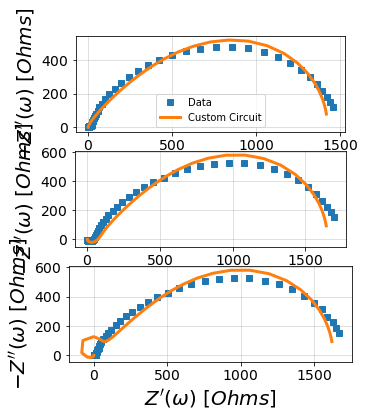

In [178]:
# C_Al=1e-4

fig=plt.figure(figsize=(6,6))
ax0=fig.add_subplot(311)
plot_nyquist(ax0, freqs, Z_corr,fmt='s')
plot_nyquist(ax0, pred_freq,custom_fit7,fmt='-')

C_mask=3e-5
R_mask2=R_mask*.1
Z2=R_mask/(1+1j*freqs*2*np.pi*R_mask*C_mask)
Z_if=R_if/(1+1j*freqs*2*np.pi*R_if*C_if)

ax1=fig.add_subplot(312)
plot_nyquist(ax1, freqs, 1/(1/Z_corr-1/Z2),fmt='s')
plot_nyquist(ax1, pred_freq,1/(1/custom_fit7-1/Z2),fmt='-')

ax2=fig.add_subplot(313)
plot_nyquist(ax2, freqs, 1/(1/(Z_corr-Z_if)-1/Z2),fmt='s')
plot_nyquist(ax2, pred_freq,1/(1/(custom_fit7-Z_if)-1/Z2),fmt='-')

ax0.legend(['Data','Custom Circuit'])

In [169]:
print(Z2)

[6.71865871e-06-2.65486424e-01j 1.12073993e-05-3.42888918e-01j
 1.86950665e-05-4.42858041e-01j 3.11852654e-05-5.71973290e-01j
 5.20201278e-05-7.38731697e-01j 8.67747796e-05-9.54108545e-01j
 1.44749061e-04-1.23227859e+00j 2.41456109e-04-1.59154939e+00j
 4.02773042e-04-2.05556501e+00j 6.71866053e-04-2.65486451e+00j
 1.12073981e-03-3.42888882e+00j 1.86950632e-03-4.42857963e+00j
 3.11852562e-03-5.71973122e+00j 5.20201023e-03-7.38731334e+00j
 8.67747086e-03-9.54107764e+00j 1.44748863e-02-1.23227690e+01j
 2.41455559e-02-1.59154577e+01j 4.02771511e-02-2.05555720e+01j
 6.71861569e-02-2.65484724e+01j 1.12072795e-01-3.42885255e+01j
 1.86947334e-01-4.42850150e+01j 3.11843160e-01-5.71956084e+01j
 5.20175486e-01-7.38695071e+01j 8.67676033e-01-9.54029639e+01j
 1.44729093e+00-1.23210860e+02j 2.41400553e+00-1.59118320e+02j
 4.02618478e+00-2.05477619e+02j 6.71435855e+00-2.65316504e+02j
 1.11954389e+01-3.42522993e+02j 1.86618099e+01-4.42070241e+02j
 3.10928366e+01-5.70278041e+02j 5.17634477e+01-7.350866